In [6]:
from baselines import MLPClassifier, LinearClassifier
from easyeditor import KEIDDataset
from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import LogisticRegression
import argparse
import pickle
import logging
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
torch.manual_seed(42)
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
type_mapping = {
    "Non edited": 0,
    "Fact updating": 1,
    "Misinformation injection": 2,
    "Offensiveness injection": 3,
    "Behavioral misleading injection": 4,
    "Bias injection": 5
}
LOG = logging.getLogger(__name__)


### Load features

In [7]:
edit_method = 'grace'
# edit_method = 'unke'
# edit_method = 'ft'

# llm = 'llama3.1'
llm = 'llama2'

with open(f'./features/{edit_method}_{llm}_testset_token_6.pkl', 'rb') as f:
    test = pickle.load(f)

all_test_hs = test['hidden_states']

np_test_hs = []
for hs in all_test_hs:
    np_test_hs.append(hs[-1].numpy())
np_test_hs = np.array(np_test_hs)

with open(f'./features/{edit_method}_{llm}_trainset_token_6.pkl', 'rb') as f:
    train = pickle.load(f)

all_train_hs = train['hidden_states']

np_train_hs = []
for hs in all_train_hs:
    np_train_hs.append(hs[-1].numpy())
np_train_hs = np.array(np_train_hs)



### Define metrics

In [8]:
def metrics(test_set, predictions):
    labels = np.array([label for _, label in test_set])

    # 1. 计算Precision, Recall和F1 Score
    precision = precision_score(labels, predictions, average='macro')  # 'macro'表示对每个类别取平均
    recall = recall_score(labels, predictions, average='macro')
    f1 = f1_score(labels, predictions, average='macro')

    # 2. 打印结果
    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'F1 Score: {f1:.3f}')

    conf_matrix = confusion_matrix(labels, predictions)

    # 2. 打印混淆矩阵
    print("Confusion Matrix:")
    print(conf_matrix)

### PCA 二维

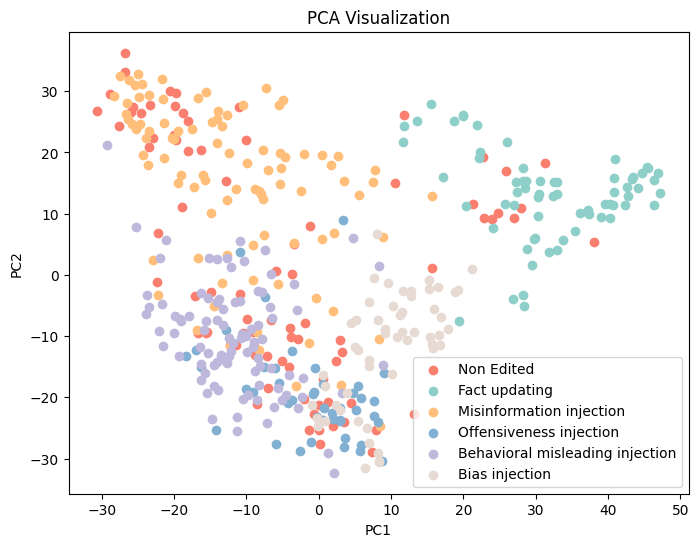

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler





# 假设你的tensor数据为X (418, n_features)，标签为y (418,)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(np_hs)
labels = list(type_mapping.keys())
colors = ['#FA7F6F', '#8ECFC9', '#FFBE7A', '#82B0D2', '#BEB8DC', '#E7DAD2']
# PCA降维到2维
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
y = np.array([label for _, label in test_set])
# 绘图
plt.figure(figsize=(8,6))
for i in range(6):  # 标签范围为0-5
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], label=labels[i], color = colors[i])
plt.legend()
plt.title('PCA Visualization')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


### PCA三维

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# 假设你的数据和标签
# data = pd.DataFrame(...)
# labels = np.array([...])  # 标签是一个长度为418的向量，取值在0-5之间

# 1. 数据标准化
scaler = StandardScaler()
data_scaled = scaler.fit_transform(np_hs)

# 2. PCA降维到3D
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_scaled)

# 3. 创建颜色映射，使用Seaborn的调色板
palette = sns.color_palette("hsv", 6)  # 6种颜色，分别对应0到5的标签
labels = np.array([label for _, label in test_set])
colors = [palette[label] for label in labels]

# 4. 三维可视化
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图，使用不同颜色表示不同的标签
scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=colors)

# 添加标签
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

# 添加图例
handles, _ = scatter.legend_elements()
legend_labels = np.unique(labels)
legend = ax.legend(handles, legend_labels, title="Labels", loc="best")

plt.show()


### LDA一维

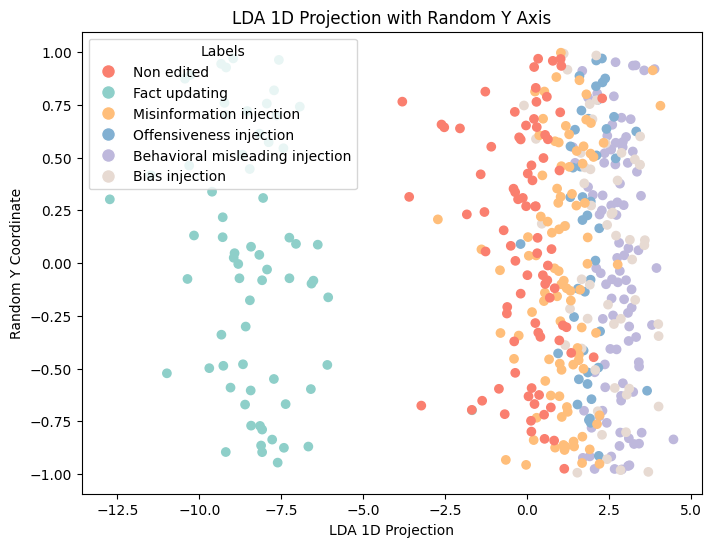

In [9]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import seaborn as sns

# 假设你的数据和标签
# data = pd.DataFrame(...)  # 你的n_features维数据
# labels = np.array([...])  # 418维标签，取值为0到5的整数

# 1. 使用LDA将数据降维到1维
lda = LDA(n_components=1)
y = np.array([label for _, label in test_set])
lda_result = lda.fit_transform(np_hs, y)
labels = list(type_mapping.keys())
# 2. 随机生成y坐标（第二个维度的值）
y_random = np.random.uniform(-1, 1, size=lda_result.shape[0])

# 3. 创建颜色映射，使用Seaborn的调色板
palette = ['#FA7F6F', '#8ECFC9', '#FFBE7A', '#82B0D2', '#BEB8DC', '#E7DAD2']
colors = [palette[label] for label in y]

# 4. 二维可视化
plt.figure(figsize=(8, 6))
plt.scatter(lda_result[:, 0], y_random, c=colors)

# 添加标签
plt.xlabel('LDA 1D Projection')
plt.ylabel('Random Y Coordinate')
plt.title('LDA 1D Projection with Random Y Axis')

# 添加图例
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[i], markersize=10) for i in range(6)]
plt.legend(handles, [labels[i] for i in range(6)], title="Labels", loc="best")

plt.show()


### LDA二维

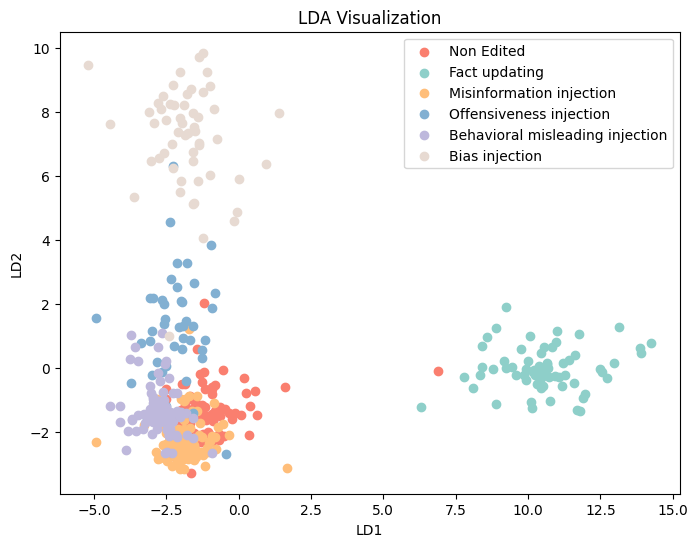

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(np_hs)
# LDA降维到2维
lda = LDA(n_components=2)
X_lda = lda.fit_transform(X_scaled, y)

colors = ['#FA7F6F', '#8ECFC9', '#FFBE7A', '#82B0D2', '#BEB8DC', '#E7DAD2']
# 绘图
plt.figure(figsize=(8,6))
for i in range(6):
    plt.scatter(X_lda[y == i, 0], X_lda[y == i, 1], label=labels[i], color=colors[i])
plt.legend()
plt.title('LDA Visualization')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.show()


### LDA三维

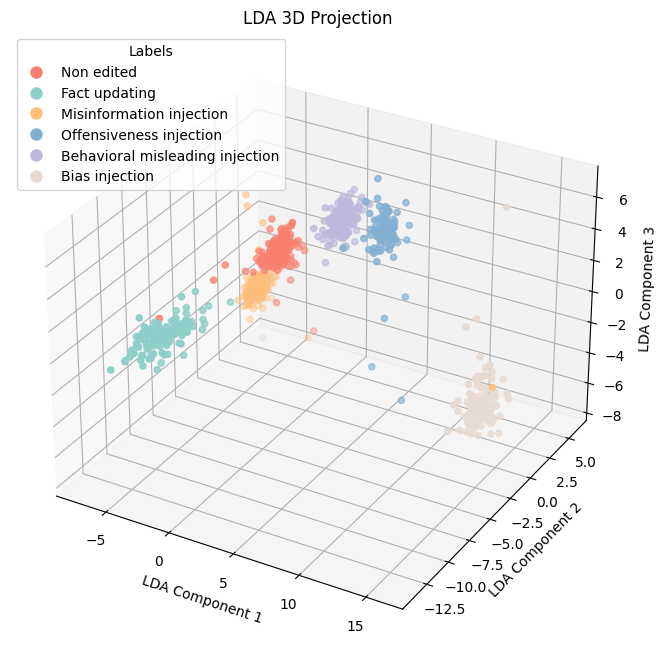

Precision: 0.775
Recall: 0.780
F1 Score: 0.777
Confusion Matrix:
[[53  3 19  2  6  0]
 [ 1 65  1  0  0  0]
 [19  0 63  3  8  0]
 [ 3  0  0 34  2  5]
 [13  0  6  6 68  0]
 [ 1  0  0  4  1 48]]


In [9]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# 假设你的数据和标签
# data = pd.DataFrame(...)  # 你的n_features维数据
# labels = np.array([...])  # 418维标签，取值为0到5的整数


# 1. 使用LDA将数据降维到3维
lda = LDA(n_components=3)
y = np.array([label for _, label in train_set])
lda.fit(np_train_hs, y)
lda_result = lda.transform(np_train_hs)
labels = list(type_mapping.keys())

# 2. 创建颜色映射，使用Seaborn的调色板
palette = ['#FA7F6F', '#8ECFC9', '#FFBE7A', '#82B0D2', '#BEB8DC', '#E7DAD2']
colors = [palette[label] for label in y]

# 3. 三维可视化
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制三维散点图，使用不同颜色表示不同的标签
scatter = ax.scatter(lda_result[:, 0], lda_result[:, 1], lda_result[:, 2], c=colors)

# 添加标签
ax.set_xlabel('LDA Component 1')
ax.set_ylabel('LDA Component 2')
ax.set_zlabel('LDA Component 3')
ax.set_title('LDA 3D Projection')

# 添加图例
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[i], markersize=10) for i in range(6)]
ax.legend(handles, [labels[i] for i in range(6)], title="Labels", loc="best")

plt.show()

predictions = lda.predict(np_test_hs)
metrics(test_set, predictions)

### 逻辑回归

In [10]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 创建逻辑回归模型实例
model = LogisticRegression( solver='lbfgs', max_iter=1000)

# 训练模型
y = np.array([label for _, label in train_set])

model.fit(np_train_hs, y)
# 预测测试集
predictions = model.predict(np_test_hs)
metrics(test_set, predictions)

Precision: 0.815
Recall: 0.820
F1 Score: 0.816
Confusion Matrix:
[[57  4 17  0  4  1]
 [ 0 67  0  0  0  0]
 [10  0 73  0  7  3]
 [ 2  0  1 32  2  7]
 [ 8  0  4  7 74  0]
 [ 0  0  2  2  0 50]]


### 区分编辑和非编辑

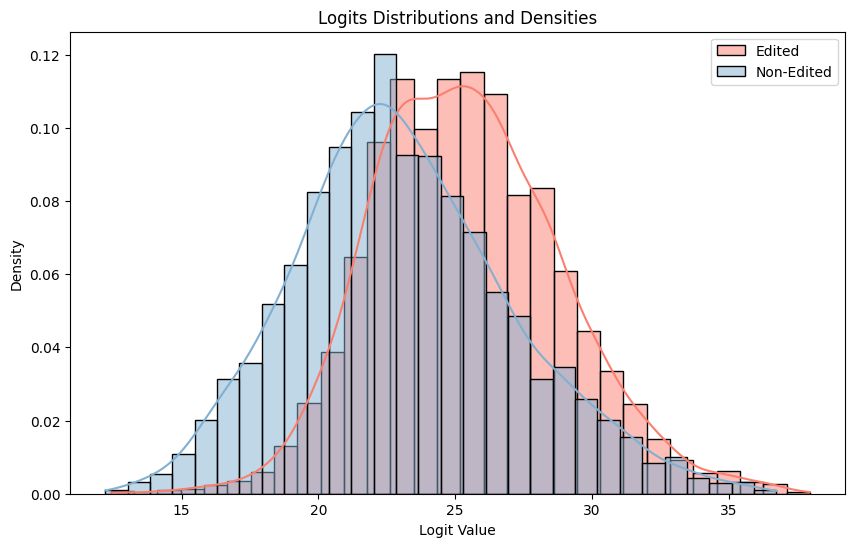

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 假设有两个 logits 数组
logits_1 = np.array(all_max_logits_edited)
logits_2 = np.array(all_max_logits_normal)

# 创建画布
plt.figure(figsize=(10, 6))

# 绘制第一个logits的直方图和密度
sns.histplot(logits_1, bins=30, kde=True, color='#FA7F6F', label='Edited', stat='density')

# 绘制第二个logits的直方图和密度
sns.histplot(logits_2, bins=30, kde=True, color='#82B0D2', label='Non-Edited', stat='density')

# 添加图例和标签
plt.legend(loc='upper right')
plt.title('Logits Distributions and Densities')
plt.xlabel('Logit Value')
plt.ylabel('Density')

# 显示图像
plt.show()


### logprob的热力图

In [ ]:
all_edited_top_k_tokens_log_probs[0]

[{'token_ids': tensor([ 1270,  1035,   358, 57277,  9520,   334, 13220, 11453,  1472,  2650,
          52050,  1442,   220,  1054, 30184,   320,  5629,   482,  2476,  3639]),
  'logprobs': tensor([-1.7162, -1.8613, -3.3364, -3.6171, -3.6724, -3.7524, -3.8429, -4.1617,
          -4.1625, -4.2120, -4.4700, -4.5143, -4.5364, -4.5802, -4.6114, -4.7113,
          -4.7904, -4.8301, -4.8513, -4.8752])},
 {'token_ids': tensor([    9,     6,   791,    40, 42069,  2675,  2028,  2746,    32,  2181,
           8100,   644,   334,  4599,    12, 17773,    17,  4438,  7927,  1548]),
  'logprobs': tensor([-2.5895, -2.7409, -2.8335, -3.4394, -3.4872, -3.6082, -3.6615, -3.6815,
          -4.2173, -4.2208, -4.2337, -4.2855, -4.3251, -4.5246, -4.6113, -4.6618,
          -4.7087, -4.8137, -4.8538, -4.8711])},
 {'token_ids': tensor([ 364,  256,  510,  220, 3146,  721,  330,  358, 3639, 2650,  578, 1442,
          1472,  362, 4438, 3923, 2746,  320, 2675,  791]),
  'logprobs': tensor([-0.9589, -1.8686, -3.37

In [12]:
all_log_probs = []
for edited_top_k_tokens_log_probs in all_edited_top_k_tokens_log_probs:
    step_log_probs = []
    for step in edited_top_k_tokens_log_probs:
        step_log_probs.append(step['logprobs'])
    all_log_probs.append(torch.stack(step_log_probs))
all_log_probs_tensor = torch.stack(all_log_probs)

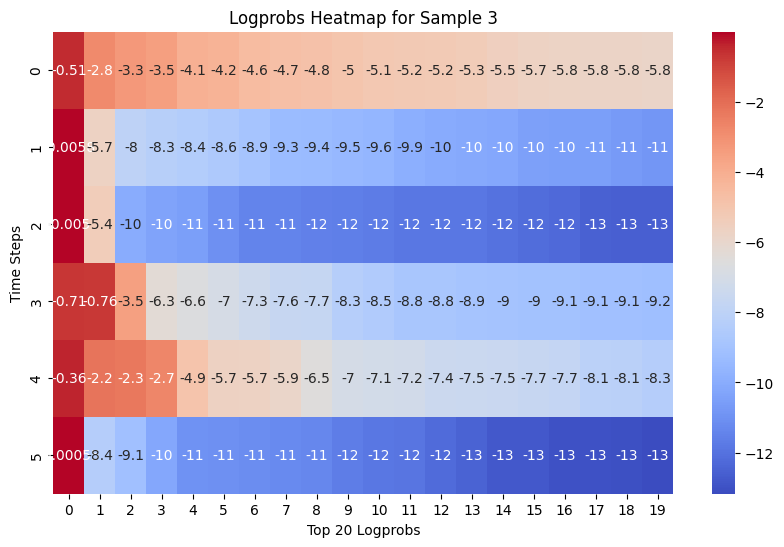

In [8]:

# 选择第一个样本进行可视化
sample_index = 3
logprobs_sample = all_log_probs_tensor[sample_index]

# 绘制热力图
plt.figure(figsize=(10, 6))
sns.heatmap(logprobs_sample.numpy(), cmap="coolwarm", annot=True)
plt.title(f'Logprobs Heatmap for Sample {sample_index}')
plt.xlabel('Top 20 Logprobs')
plt.ylabel('Time Steps')
plt.show()

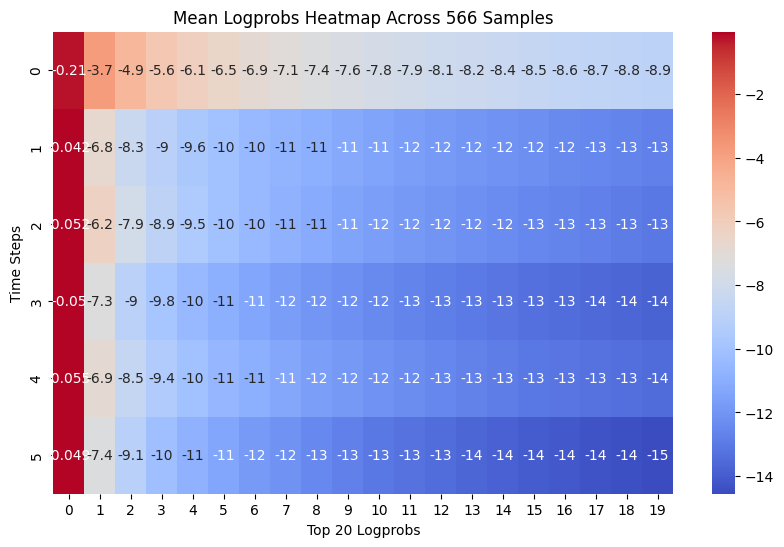

In [13]:
mean_logprobs = all_log_probs_tensor.mean(dim=0)  # (6, 20) 形状

# 绘制平均热力图
plt.figure(figsize=(10, 6))
sns.heatmap(mean_logprobs.numpy(), cmap="coolwarm", annot=True)
plt.title(f'Mean Logprobs Heatmap Across {all_log_probs_tensor.shape[0]} Samples')
plt.xlabel('Top 20 Logprobs')
plt.ylabel('Time Steps')
plt.show()

### 区分编辑中的不同类型

09/11/2024 18:09:18 - WARNING - matplotlib.legend -   No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


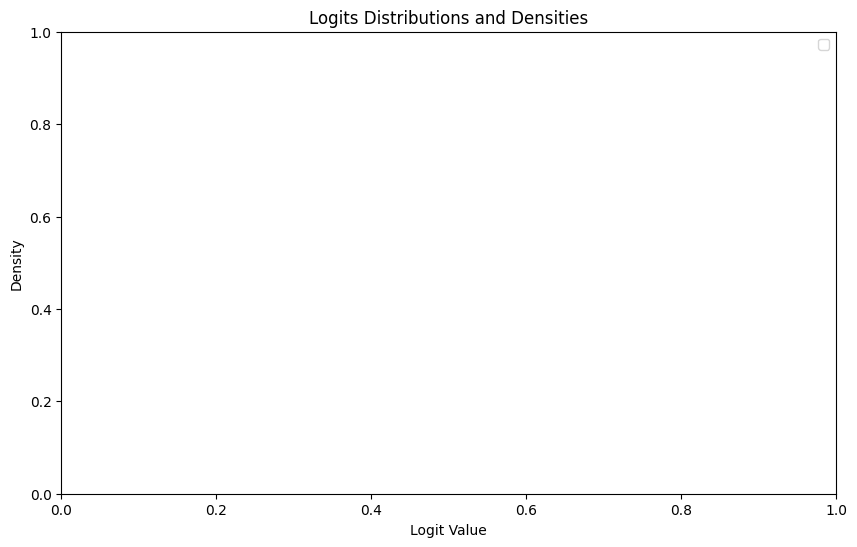

In [21]:
# 假设有两个 logits 数组
logits_1 = np.array(all_max_logits_edited)


# 创建画布
plt.figure(figsize=(10, 6))

# 绘制第一个logits的直方图和密度
# colors = ['#FA7F6F', '#8ECFC9', '#FFBE7A', '#82B0D2','#BEB8DC']
# labels = ['Behavioral misleading injection', 'Fact updating', 'Misinformation injection', 'Offensiveness injection', 'Bias injection']

colors = ['#FA7F6F', '#8ECFC9', '#FFBE7A', '#82B0D2']
labels = ['Behavioral misleading injection', 'Offensiveness injection', 'Bias injection', 'Misinformation injection']
index = [0, len(behavior), len(behavior) + len(offensive), len(behavior) + len(offensive) + len(bias), len(behavior) + len(offensive) + len(bias) + len(misinfor)]

for i in range(4):
    sns.histplot(logits_1[index[i] : index[i+1]], bins=30, kde=True, color=colors[i], label=labels[i], stat='density')


# 添加图例和标签
plt.legend(loc='upper right')
plt.title('Logits Distributions and Densities')
plt.xlabel('Logit Value')
plt.ylabel('Density')

# 显示图像
plt.show()

## Hidden states区别

### 编辑 vs. 非编辑

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_hidden_states(states1, states2, method='pca'):
    """
    Visualize two sets of hidden states using PCA or t-SNE.
    
    :param states1: numpy array of hidden states from first model
    :param states2: numpy array of hidden states from second model
    :param method: 'pca' or 'tsne'
    """
    # Combine the states
    combined_states = np.vstack((states1, states2))
    
    # Apply dimensionality reduction
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")
    
    reduced_states = reducer.fit_transform(combined_states)
    
    # Split the reduced states back into two groups
    reduced_states1 = reduced_states[:len(states1)]
    reduced_states2 = reduced_states[len(states1):]
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_states1[:, 0], reduced_states1[:, 1], c='blue', label='non-edited', alpha=0.6)
    plt.scatter(reduced_states2[:, 0], reduced_states2[:, 1], c='red', label='edited', alpha=0.6)
    plt.title(f'Hidden States Visualization using {method.upper()}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()

# Example usage (you'll need to replace these with your actual data)
# states1 = np.random.rand(100, 768)  # 100 samples, 768 dimensions
# states2 = np.random.rand(100, 768)
# visualize_hidden_states(states1, states2, method='pca')
# visualize_hidden_states(states1, states2, method='tsne')

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def visualize_hidden_states_lda(states1, states2):
    """
    Visualize two sets of hidden states using Linear Discriminant Analysis (LDA).
    
    :param states1: numpy array of hidden states from the first model
    :param states2: numpy array of hidden states from the second model
    """
    # Combine the states
    combined_states = np.vstack((states1, states2))
    
    # Create labels: 0 for states1, 1 for states2
    labels = np.array([0]*len(states1) + [1]*len(states2))
    
    # Apply LDA
    lda = LinearDiscriminantAnalysis(n_components=1)
    reduced_states = lda.fit_transform(combined_states, labels)
    
    # Split the reduced states back into two groups
    reduced_states1 = reduced_states[:len(states1)]
    reduced_states2 = reduced_states[len(states1):]
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_states1, np.zeros_like(reduced_states1), 
                c='blue', label='Non-edited', alpha=0.6, marker='o')
    plt.scatter(reduced_states2, np.zeros_like(reduced_states2), 
                c='red', label='Edited', alpha=0.6, marker='x')
    
    # Enhance visualization by adding jitter
    jitter_strength = 0.02  # Adjust as needed
    plt.scatter(reduced_states1, np.random.normal(0, jitter_strength, size=reduced_states1.shape),
                c='blue', alpha=0.6, marker='o')
    plt.scatter(reduced_states2, np.random.normal(0, jitter_strength, size=reduced_states2.shape),
                c='red', alpha=0.6, marker='x')
    
    plt.title('Hidden States Visualization using LDA')
    plt.xlabel('LDA Component 1')
    plt.yticks([])  # Hide y-axis ticks since it's not meaningful in 1D
    plt.legend()
    plt.show()

In [7]:
np_hs_edited = []
np_hs_normal = []
for hs_edited, hs_normal in zip(all_hs_edited, all_hs_normal):
    np_hs_edited.append(hs_edited[-1].numpy())
    np_hs_normal.append(hs_normal[-1].numpy())
np_hs_edited = np.array(np_hs_edited)
np_hs_normal = np.array(np_hs_normal)

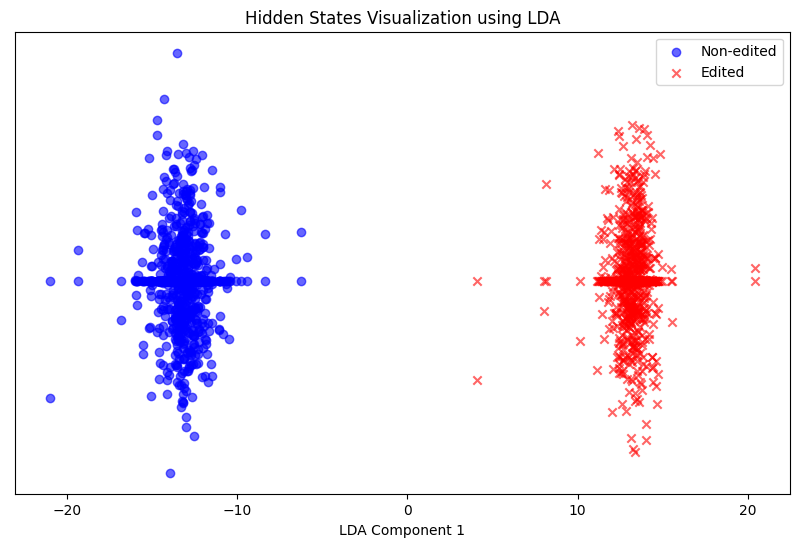

In [13]:
visualize_hidden_states(np_hs_normal, np_hs_edited)

### 编辑的 不同类型的区别

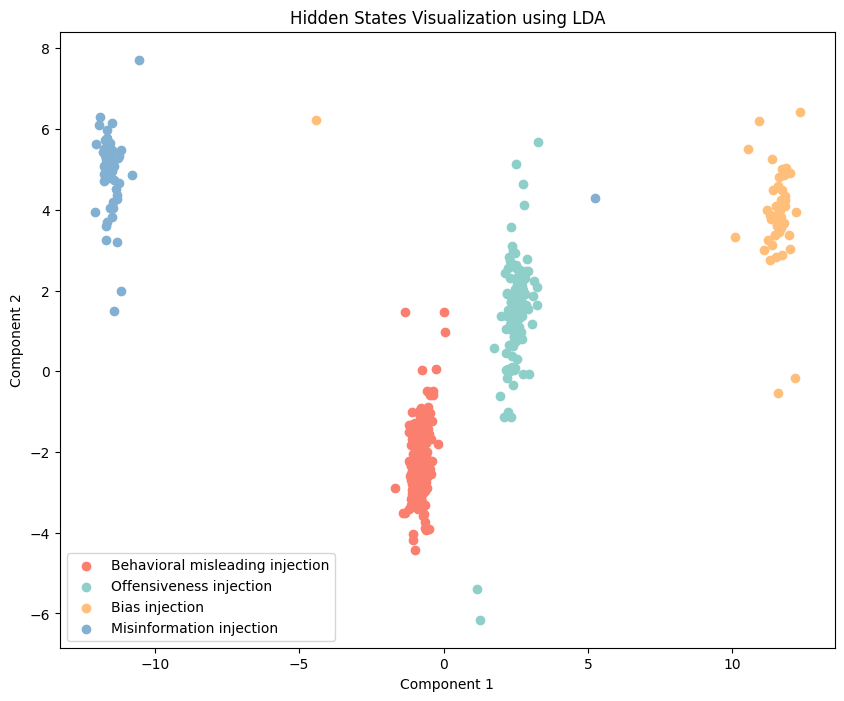

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def visualize_hidden_states_serise_hs(all_hs, interval=3,method='pca'):
    """
    Visualize two sets of hidden states using PCA or t-SNE.
    
    :param states1: numpy array of hidden states from first model
    :param states2: numpy array of hidden states from second model
    :param method: 'pca' or 'tsne'
    """

    # Apply dimensionality reduction
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    elif method == 'lda':
        reducer = LinearDiscriminantAnalysis(n_components=2)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")
    
    if method == 'lda':
        labels = np.array([0] * len(behavior) + 
                      [1] * len(offensive) + 
                      [2] * len(bias) + 
                      [3] * len(misinfor))
        reduced_states = reducer.fit_transform(all_hs, labels)
    else:
        reduced_states = reducer.fit_transform(all_hs)
    
    
    # Plot
    plt.figure(figsize=(10, 8))
    # assert len(all_hs) / interval != 0
    # for i in range(5):
    #     plt.scatter(reduced_states[i*interval: (i+1)*interval, 0], reduced_states[i*interval: (i+1)*interval, 1], c=colors[i], label=labels[i])

    colors = ['#FA7F6F', '#8ECFC9', '#FFBE7A', '#82B0D2']
    labels = ['Behavioral misleading injection', 'Offensiveness injection', 'Bias injection', 'Misinformation injection']
    index = [0, len(behavior), len(behavior) + len(offensive), len(behavior) + len(offensive) + len(bias), len(behavior) + len(offensive) + len(bias) + len(misinfor)]
    for i in range(4):
        plt.scatter(reduced_states[index[i]: index[i+1], 0], reduced_states[index[i]: index[i+1], 1], c=colors[i], label=labels[i])

    plt.title(f'Hidden States Visualization using {method.upper()}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()

visualize_hidden_states_serise_hs(np_hs_edited,method='lda')